In [1]:
import torch
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts, plot_one_box

from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, xywhn2xyxy, strip_optimizer, set_logging, increment_path

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
weigths = torch.load('../runs/train/yolov7-w6-pose56/weights/best.pt')
# weigths = torch.load('../weights/yolov7-w6-pose.pt')
model = weigths['model']
model = model.half().to(device)
_ = model.eval()

In [5]:
img = cv2.imread('../yolo_robot_pose/images/train/0006.jpg')
# img = cv2.imread('../test2.jpeg')

In [6]:
image = letterbox(img, 640, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)
image = image.half()

In [7]:
output, _ = model(image)
output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)

/home/reza/yolov7_env/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
with torch.no_grad():
    output = output_to_keypoint(output)

In [9]:
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    xmin, ymin = (output[idx, 2]-output[idx, 4]/2), (output[idx, 3]-output[idx, 5]/2)
    xmax, ymax = (output[idx, 2]+output[idx, 4]/2), (output[idx, 3]+output[idx, 5]/2)
    cv2.rectangle(
      nimg,
      (int(xmin), int(ymin)),
      (int(xmax), int(ymax)),
      color=(255, 0, 0),
      thickness=1,
      lineType=cv2.LINE_AA
    )

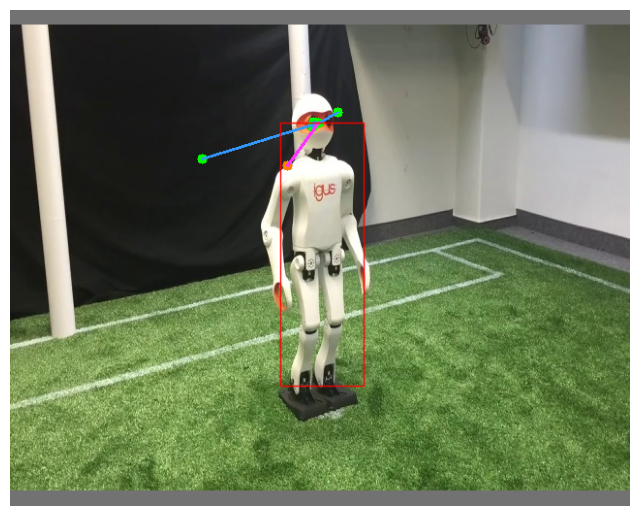

In [10]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()

In [2]:
img = cv2.imread('../yolo_robot_pose/images/train/0006.jpg')
dh, dw, _ = img.shape

In [3]:
kpt_label = True
nkpt = 6
annotation = []
lb_file = '../yolo_robot_pose/labels/train/0006.txt'
with open(lb_file, 'r') as f:
    annotation = [x.split() for x in f.read().strip().splitlines()]
    if any([len(x) > 8 for x in annotation]) and not kpt_label:  # is segment
        classes = np.array([x[0] for x in annotation], dtype=np.float32)
        segments = [np.array(x[1:], dtype=np.float32).reshape(-1, 2) for x in annotation]  # (cls, xy1...)
        annotation = np.concatenate((classes.reshape(-1, 1), segments2boxes(segments)), 1)  # (cls, xywh)
    annotation = np.array(annotation, dtype=np.float32)
if len(annotation):
    assert (annotation >= 0).all(), 'negative labels'
    if kpt_label:
        assert annotation.shape[1] == 5 + 3*nkpt, f'labels require {5 + nkpt * 3} columns each'
        assert (annotation[:, 5::3] <= 1).all(), 'non-normalized or out of bounds coordinate labels'
        assert (annotation[:, 6::3] <= 1).all(), 'non-normalized or out of bounds coordinate labels'
        # print("annotation shape", annotation.shape)
        kpts = np.zeros((annotation.shape[0], nkpt * 2 + 5))
        for i in range(len(annotation)):
            kpt = np.delete(annotation[i,5:], np.arange(2, annotation.shape[1]-5, 3))  #remove the occlusion paramater from the GT
            kpts[i] = np.hstack((annotation[i, :5], kpt))
        annotation = kpts
        assert annotation.shape[1] == 5 + 2*nkpt, f'labels require {5 + nkpt * 2} columns each after removing occlusion paramater'
    else:
        assert annotation.shape[1] == 5, 'labels require 5 columns each'
        assert (annotation[:, 1:5] <= 1).all(), 'non-normalized or out of bounds coordinate labels'

    assert np.unique(annotation, axis=0).shape[0] == annotation.shape[0], 'duplicate labels'
else:
    ne += 1  # label empty
    annotation = np.zeros((0, 5 + 2*self.nkpt), dtype=np.float32) if kpt_label else np.zeros((0, 5), dtype=np.float32)

In [5]:
annotation

array([[          0,         0.5,     0.49583,     0.13125,      0.5625,     0.49062,     0.21458,         0.5,     0.47708,     0.43437,     0.54375,     0.56563,     0.51042,       0.475,     0.77708,     0.51406,     0.76042]])

In [6]:
xywhn2xyxy(annotation[:, 1:], dw, dh, padw=0, padh=0)

array([[        278,         103,         362,         373,     0.49062,     0.21458,         0.5,     0.47708,     0.43437,     0.54375,     0.56563,     0.51042,       0.475,     0.77708,     0.51406,     0.76042]])

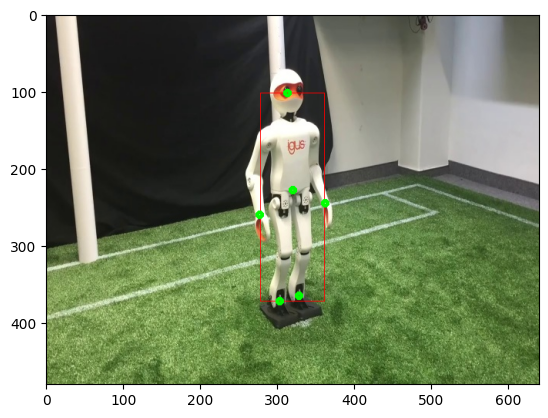

In [4]:
for dt in annotation:
    # Split string to float
    _, x, y, w, h = dt[:5]
    keypoints = dt[5:]

    # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
    # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    
    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)
    
    for i in range(0, len(keypoints), 2):
        kpx,kpy = keypoints[i:i+2]
        kpx = int(kpx * dw)
        kpy = int(kpy * dh)
        cv2.circle(img, (kpx,kpy), 3, (0,255,0), 3)

plt.imshow(img[:, :, ::-1])